In [ ]:
import pandas as pd
import numpy as np

In [7]:
# Read the data from CSV files
n = ['id', 'date','name','text','typr','rep','rtw','faw','stcount','foll','frien','listcount']
data_positive = pd.read_csv('positive.csv', sep=';',error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('negative.csv', sep=';',error_bad_lines=False, names=n, usecols=['text'])

In [8]:
# Create balanced dataset
sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size], 
                           data_negative['text'].values[:sample_size]), axis=0) 
labels = [1]*sample_size + [0]*sample_size

In [9]:
import re
from sklearn.model_selection import train_test_split, GridSearchCV
def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    return text.strip()

data = [preprocess_text(t) for t in raw_data]
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=40000, test_size=10000, shuffle=True, random_state=42)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer


max_f = 20000

vectorizer_names = ["1-grams", "1- and 2-grams", "2-grams"]
vectorizers = [CountVectorizer(ngram_range=(1,1), max_features=20000),
               CountVectorizer(ngram_range=(1,2), max_features=20000),
               CountVectorizer(ngram_range=(2,2), max_features=20000)]

transformer_names = [
                     "TF l2 log",
                     "TF l2 linear",
                     "TF-IDF l2 log",
                     "TF-IDF l2 linear",]
transformers = [
                TfidfTransformer(use_idf=True, norm='l2', sublinear_tf=True),
                TfidfTransformer(use_idf=True, norm='l2', sublinear_tf=False),
                TfidfTransformer(use_idf=False, norm='l2', sublinear_tf=True),
                TfidfTransformer(use_idf=False, norm='l2', sublinear_tf=False),]

classifier_names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    MultinomialNB(),
    ]



In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import timeit
res_arr = []

for vectorizer, vectorizer_name in zip(vectorizers, vectorizer_names):
    v_t0 = timeit.default_timer()
    x_train_counted = vectorizer.fit_transform(x_train)
    x_test_counted = vectorizer.transform(x_test)
    v_time = round(timeit.default_timer()- v_t0, 2)
    for transformer, transformer_name in zip(transformers, transformer_names):
        t_t0 = timeit.default_timer()
        x_train_transformed = transformer.fit_transform(x_train_counted)
        x_test_transformed = transformer.transform(x_test_counted)
        t_time = round(timeit.default_timer()- t_t0, 2)
        for classifier, classifier_name in zip(classifiers, classifier_names):
            c_t0 = timeit.default_timer()
            classifier.fit(x_train_transformed, y_train)
            y_pred = classifier.predict(x_test_transformed)
            c_time = round(timeit.default_timer()- c_t0, 2)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
            res = {
                'vectorizer': vectorizer_name,
                'transformer': transformer_name,
                'classifier': classifier_name,
                'accuracy': accuracy,
                'f1_score': f1,
                'precision': precision,
                'recall': recall,
                'fscore': fscore,
                'support': support,
                'vectorizer_time': v_time,
                'transformer_time': t_time,
                'classifier_time': c_time
            }
            res_arr.append(res)
            print(res)

{'vectorizer': '1-grams', 'transformer': 'TF l2 log', 'classifier': 'Nearest Neighbors', 'accuracy': 0.5236, 'f1_score': 0.1498929336188437, 'precision': array([0.5090371 , 0.77922078]), 'recall': array([0.97588652, 0.08292201]), 'fscore': array([0.66907474, 0.14989293]), 'support': array([4935, 5065], dtype=int64), 'vectorizer_time': 0.69, 'transformer_time': 0.03, 'classifier_time': 10.09}
{'vectorizer': '1-grams', 'transformer': 'TF l2 log', 'classifier': 'Linear SVM', 'accuracy': 0.6745, 'f1_score': 0.6770512947713067, 'precision': array([0.66847172, 0.68049462]), 'recall': array([0.67537994, 0.67364265]), 'fscore': array([0.67190807, 0.67705129]), 'support': array([4935, 5065], dtype=int64), 'vectorizer_time': 0.69, 'transformer_time': 0.03, 'classifier_time': 184.24}
{'vectorizer': '1-grams', 'transformer': 'TF l2 log', 'classifier': 'RBF SVM', 'accuracy': 0.7247, 'f1_score': 0.7265322340319857, 'precision': array([0.71828731, 0.73110756]), 'recall': array([0.72745694, 0.72201382

{'vectorizer': '1-grams', 'transformer': 'TF-IDF l2 linear', 'classifier': 'Nearest Neighbors', 'accuracy': 0.5585, 'f1_score': 0.38191236175276494, 'precision': array([0.53281999, 0.65640038]), 'recall': array([0.85531915, 0.26929911]), 'fscore': array([0.6566073 , 0.38191236]), 'support': array([4935, 5065], dtype=int64), 'vectorizer_time': 0.69, 'transformer_time': 0.01, 'classifier_time': 10.29}
{'vectorizer': '1-grams', 'transformer': 'TF-IDF l2 linear', 'classifier': 'Linear SVM', 'accuracy': 0.6603, 'f1_score': 0.6614848031888391, 'precision': array([0.6528827 , 0.66780684]), 'recall': array([0.66545086, 0.65528134]), 'fscore': array([0.65910687, 0.6614848 ]), 'support': array([4935, 5065], dtype=int64), 'vectorizer_time': 0.69, 'transformer_time': 0.01, 'classifier_time': 195.09}
{'vectorizer': '1-grams', 'transformer': 'TF-IDF l2 linear', 'classifier': 'RBF SVM', 'accuracy': 0.716, 'f1_score': 0.7175253630395863, 'precision': array([0.70904011, 0.72299058]), 'recall': array([0

{'vectorizer': '1- and 2-grams', 'transformer': 'TF-IDF l2 log', 'classifier': 'Nearest Neighbors', 'accuracy': 0.5619, 'f1_score': 0.3666329333526095, 'precision': array([0.53399607, 0.68466523]), 'recall': array([0.8816616 , 0.25034551]), 'fscore': array([0.66513797, 0.36663293]), 'support': array([4935, 5065], dtype=int64), 'vectorizer_time': 1.94, 'transformer_time': 0.01, 'classifier_time': 10.93}
{'vectorizer': '1- and 2-grams', 'transformer': 'TF-IDF l2 log', 'classifier': 'Linear SVM', 'accuracy': 0.6589, 'f1_score': 0.6550015171437241, 'precision': array([0.64716107, 0.6715056 ]), 'recall': array([0.67902736, 0.63928924]), 'fscore': array([0.66271136, 0.65500152]), 'support': array([4935, 5065], dtype=int64), 'vectorizer_time': 1.94, 'transformer_time': 0.01, 'classifier_time': 221.97}
{'vectorizer': '1- and 2-grams', 'transformer': 'TF-IDF l2 log', 'classifier': 'RBF SVM', 'accuracy': 0.7221, 'f1_score': 0.7246060846298682, 'precision': array([0.71672698, 0.72741743]), 'recal

{'vectorizer': '2-grams', 'transformer': 'TF l2 linear', 'classifier': 'Nearest Neighbors', 'accuracy': 0.5873, 'f1_score': 0.5339356295878035, 'precision': array([0.56505636, 0.6237467 ]), 'recall': array([0.71104357, 0.46673248]), 'fscore': array([0.62969942, 0.53393563]), 'support': array([4935, 5065], dtype=int64), 'vectorizer_time': 1.52, 'transformer_time': 0.01, 'classifier_time': 6.83}
{'vectorizer': '2-grams', 'transformer': 'TF l2 linear', 'classifier': 'Linear SVM', 'accuracy': 0.5288, 'f1_score': 0.2208994708994709, 'precision': array([0.51236553, 0.67955239]), 'recall': array([0.93617021, 0.13188549]), 'fscore': array([0.66227064, 0.22089947]), 'support': array([4935, 5065], dtype=int64), 'vectorizer_time': 1.52, 'transformer_time': 0.01, 'classifier_time': 70.37}
{'vectorizer': '2-grams', 'transformer': 'TF l2 linear', 'classifier': 'RBF SVM', 'accuracy': 0.6532, 'f1_score': 0.6689576174112256, 'precision': array([0.65983874, 0.64756977]), 'recall': array([0.61357649, 0.6

In [75]:
from pandas import DataFrame
df = DataFrame(res_arr)
columns_to_split = ['fscore', 'precision', 'recall', 'support']
for column in columns_to_split:
    df[column + '_1'] = df[column].apply(lambda x: x[0])
    df[column + '_2'] = df[column].apply(lambda x: x[1])
df = df.drop(columns_to_split, axis=1)
#Результаты для светрочной нейронной сети; получены в основной программе
cnn_row = {
                'vectorizer': 'Word2Vec',
                'classifier': 'CNN',
                'accuracy': 0.7719,
                'f1_score': 0.76614,
                'fscore_1': 0.77521,
                'fscore_2': 0.76614,
                'precision_1': 0.76282,
                'precision_2': 0.77930,
                'recall_1': 0.78799,
                'recall_2': 0.75342,
                'vectorizer_time': 0,
                'transformer_time': 0,
                'classifier_time': 2830.46
            }
df = df.append(cnn_row, ignore_index=True)
df = df[['vectorizer','transformer','classifier','accuracy','f1_score','fscore_1','fscore_2','precision_1','precision_2','recall_1','recall_2','transformer_time','vectorizer_time','classifier_time']]
res_str = df.to_csv(sep=';').replace('.', ',')
f = open("comparison.csv", "w")
f.write(res_str)
f.close()

NameError: name 'res_arr' is not defined

In [96]:
import pandas
from io import StringIO
f = open("comparison.csv", "r")
raw_df = f.read().replace(',', '.')
df = pandas.read_csv(StringIO(raw_df), sep=';', index_col=False)
df = df.drop(['Unnamed: 0'], axis=1)

res_str = df.to_csv(sep=';').replace('.', ',')
f = open("comparison.csv", "w")
f.write(res_str)
f.close()

In [95]:
mean_classifiers = df.groupby('classifier').mean().reset_index()
mean_vectorizers = df.groupby('vectorizer').mean().reset_index()
mean_transformers = df[df['transformer'] != 'NaN'].groupby('transformer').mean().reset_index()
best_classifiers = df.groupby('classifier').max().reset_index()
best_vectorizers = df.groupby('vectorizer').max().reset_index()
best_transformers = df[df['transformer'] != 'NaN'].groupby('transformer').max().reset_index()

In [113]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.8)
def plot_grouped(df, group_column, xlabel, pos, ylim=(0.4, 0.83)):
    y, x, i = pos
    plt.subplot(y, x, i)
    plt.ylim(*ylim)
    
    plt.bar(df[group_column], df['f1_score'])
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('F-мера', fontsize=12)
    plt.xticks(rotation=45, fontsize=12)












<Figure size 720x864 with 0 Axes>

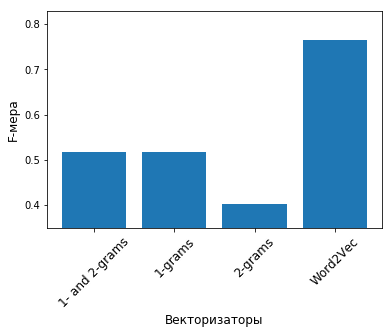

In [121]:
plot_grouped(mean_vectorizers, 'vectorizer', 'Векторизаторы', (1,1,1), ylim=(0.35, 0.83))

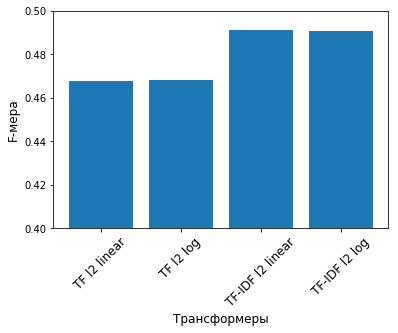

In [124]:
plot_grouped(mean_transformers, 'transformer', 'Трансформеры', (1,1,1), ylim=(0.4,0.5))

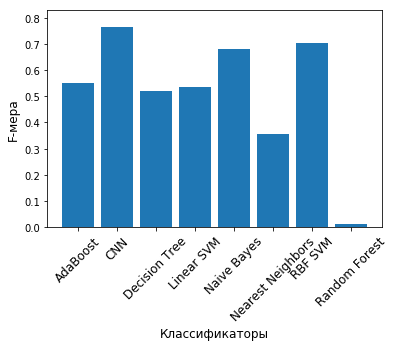

In [128]:
plot_grouped(mean_classifiers, 'classifier', 'Классификаторы', (1,1,1), ylim=(0., 0.83))

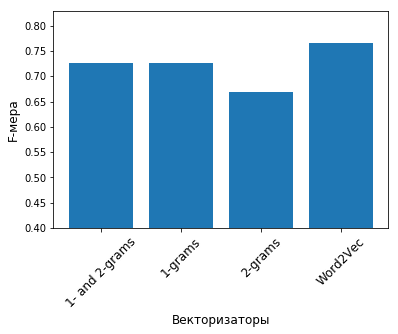

In [117]:
plot_grouped(best_vectorizers, 'vectorizer', 'Векторизаторы', (1,1,1))

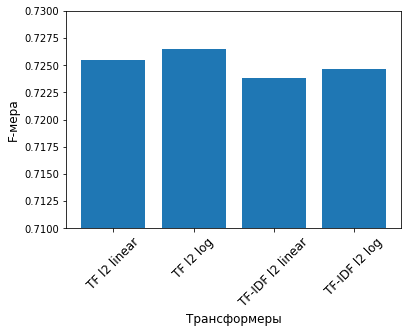

In [118]:
plot_grouped(best_transformers, 'transformer', 'Трансформеры', (1,1,1), ylim=(0.71,0.73))

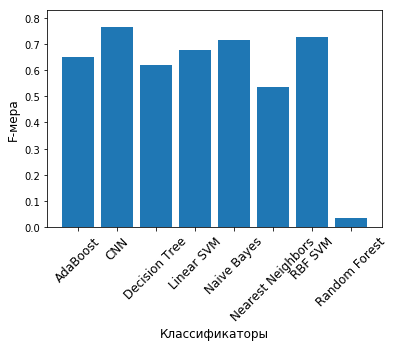

In [129]:
plot_grouped(best_classifiers, 'classifier', 'Классификаторы', (1,1,1),  ylim=(0., 0.83))

In [120]:
plt.show()